In [8]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
from utils import imshow, show_plot
from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os


In [9]:
## ploting and utils
import numpy as np
import matplotlib.pyplot as plt


def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(
            75,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

### Now to fed this raw data into our neural network, we have to turn all the images into tensors and add the labels from the CSV files to the images, to do this we can use the custom dataset class from Pytorch, here is how our full code will look like

In [10]:
# load the dataset
training_dir = "C:/Users/piyush.pathak/Downloads/siamese_net-master/siamese_net-master/train"
training_csv = "C:/Users/piyush.pathak/Downloads/siamese_net-master/siamese_net-master/train_data.csv"
testing_csv = "C:/Users/piyush.pathak/Downloads/siamese_net-master/siamese_net-master/test_data.csv"
testing_dir = "C:/Users/piyush.pathak/Downloads/siamese_net-master/siamese_net-master/test"
batch_size = 32
epochs = 20



# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):

        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)

### Now after preprocessing the dataset, in PyTorch we have to load the dataset using Dataloader class, we will use the transforms function to reduce the image size into 105 pixels of height and width for computational purposes

In [11]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)


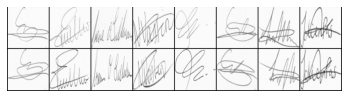

[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [17]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())


### Neural Network Architecture:
Now let’s create a neural network in Pytorch, we will use the neural network architecture which will be similar, as described in the Signet paper

In [18]:
# create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


### Loss Function:
For this task, we will use Contrastive Loss, which learns embeddings in which two similar points have a low Euclidean distance and two dissimilar points have a large Euclidean distance, In Pytorch the implementation of Contrastive Loss will be as follows,

In [19]:
import torch
import numpy as np
import torch.nn.functional as F


class ContrastiveLoss(torch.nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

In [20]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(
    siamese_dataset, shuffle=True, num_workers=8, batch_size=config.batch_size
)

In [21]:
train_dataloader

### Training the Network:
1. The training process of a Siamese network is as follows:
2. Initialize the network, loss function, and Optimizer(we will be using Adam for this project)
3. Pass the first image of the image pair through the network.
4. Pass the second image of the image pair through the network.
5. Calculate the loss using the outputs from the first and second images.
6. Back propagate the loss to calculate the gradients of our model.
7. Update the weights using an optimizer
8. Save the model

In [ ]:
# Declare Siamese Network
net = SiameseNetwork()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)

# train the model
def train():
    loss = []
    counter = []
    iteration_number = 0

    for epoch in range(1, config.epochs):
        for i, data in enumerate(train_dataloader, 0):
            img0, img1, label = data
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

        print("Epoch {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
    show_plot(counter, loss)
    return net


# set the device to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

### Testing the model:
#### Now let’s test our signature verification system on the test dataset,
1. Load the test dataset using DataLoader class from Pytorch
2. Pass the image pairs and the labels
3. Find the euclidean distance between the images
4. Based on the euclidean distance print the output

In [ ]:
# Load the test dataset
test_dataset = SiameseDataset(
    training_csv=testing_csv,
    training_dir=testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = model(x0.to(device), x1.to(device))

    eucledian_distance = F.pairwise_distance(output1, output2)

    if label == torch.FloatTensor([[0]]):
        label = "Original Pair Of Signature"
    else:
        label = "Forged Pair Of Signature"

    imshow(torchvision.utils.make_grid(concat))
    print("Predicted Eucledian Distance:-", eucledian_distance.item())
    print("Actual Label:-", label)
    count = count + 1
    if count == 10:
        break
